<a href="https://colab.research.google.com/github/diogoasilveira/KISS/blob/main/KISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KISS: Keep It Simple Search

Projeto que implementa os conceitos de LLM, RAG, Embeddings e Prompt Engineering com o objetivo de que um modelo de linguagem tenha a habilidade de responder perguntas que não possuem resposta nos dados em que ele foi treinado (e.g. notícias recentes) por meio do acesso à internet.

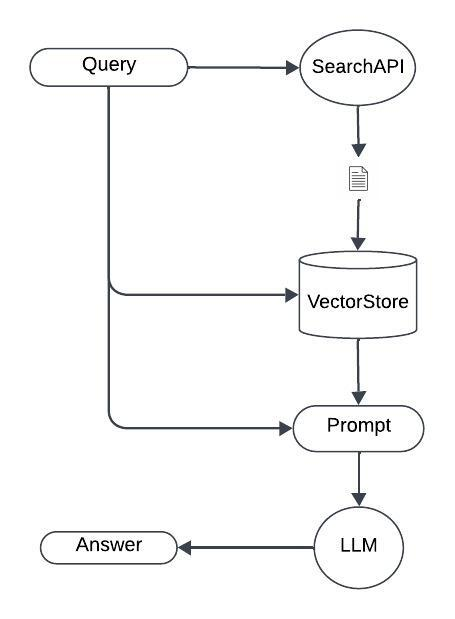

### Imports
O framework utilizado para a construção do app foi o `LangChain`, em conjunto com o modelo de linguagem `Llama 3.1 70b`, a API de pesquisa `Tavily` e `Chroma` como Vector Store.

In [ ]:
!pip install langchain-core langchain-groq langchain-community tavily-python langchain-huggingface langchain-chroma

In [ ]:
from google.colab import userdata
import os
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage, HumanMessage

In [ ]:
#env
os.environ["LANGCHAIN_TRACING_V2"]= "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]="KISS"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY2_API_KEY')

### Definições

Definição dos modelo e seus parâmetros.

In [ ]:
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0.1)

Ferramenta de pesquisa

In [ ]:
#Search Tool
tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=False,
    include_raw_content=False,
    include_images=False,
)

def get_url(tool: TavilySearchResults, query: str):
  response = tool.invoke(query)
  urls = []
  for i in response:
    urls.append(i["url"])
  return urls

Definição do modelo de embedding e a vectorstore

In [ ]:
embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vectorstore = Chroma(embedding_function=embeddings_model)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Definição de como serão carregados, pre-processados e divididos os documentos.

In [ ]:
#Store
def store_vector(vectorstore: Chroma, docs):
  vectorstore.add_documents(docs)

In [ ]:
#Vector Store
def load_data(urls):
  loader = WebBaseLoader(
    web_paths=urls,
  )
  data = loader.load()
  return data

In [ ]:
#Pre-processamento dos documentos
import re

def normalize_text(docs):
  for doc in docs:
    text = doc.page_content
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    doc.page_content = text

  return docs

In [ ]:
#Divisor dos documentos
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

In [ ]:
#Retriever
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10})

Prompt que junta a query com os documentos recuperados pelo retriever, além de especificar como deve ser feita a resposta e seu formato de saída.

In [ ]:
#Prompt
system_prompt = (
  "###Instruções###"
  "Aja como um jornalista profissional responsável por fazer um resumo das"
  "notícias recentes com objetivo de atrair os usuários que lêem apenas o título das notícias."
  "Você é um jornalista. Resuma as notícias que envolvem o tópico."
  "Se não conseguir fazer o resumo, responda que não tem conhecimentos sobre o tema."
  "Dê para os usuários um resumo conciso e coeso sobre a notícia em até 5 frases."
  "Escreva o texto usando linguagem profissional."
  "Fale apenas sobre elementos presentes no contexto apresentado abaixo:"
  "\n"
  "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

Definição do pipeline que irá juntar a query aos documentos recuperados pelo retriever em um prompt e passar tudo para o modelo de linguagem.

In [ ]:
#Chain
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
#Generation
def prompt_making(prompt:ChatPromptTemplate, query: str) -> dict:
  response = rag_chain.invoke(
      {"input": query}
  )
  return response

Formatação da resposta e inclusão das referências/fontes.

In [ ]:
#Deixa o retorno bonito
def format_to_markdown(raw_text: str) -> str:
    # Limpar quebras de linha desnecessárias
    clean_text = re.sub(r"\s+", " ", raw_text.strip())

    # Separar o título do restante
    if ": " in clean_text:
        title, content = clean_text.split(": ", 1)
        markdown_text = f"# {title.strip()}\n\n"
    else:
        content = clean_text
        markdown_text = ""

    # Encontrar os itens com bullet points e formatar
    items = re.findall(r"\* \*\*(.*?)\*\*: (.*?)\*", content)
    if items:
        for item_title, item_content in items:
            markdown_text += f"## {item_title.strip()}\n\n{item_content.strip()}\n\n"
    else:
        # Caso não haja bullet points, apenas adicionar o texto bruto
        markdown_text += content

    return markdown_text

In [ ]:
#Insere as fontes do texto no final da resposta.
def insert_source(resposta: dict) -> str:
  sources = []
  context = resposta.get("context")
  for doc in context:
    source = doc.metadata.get("source") + " \n"
    if source not in sources:
      sources.append(source)
    if len(sources) == 5: break

  sources_str = " ".join(sources)
  answer = format_to_markdown(resposta.get("answer")) + "\nLeia mais em: \n" + sources_str
  return answer

Encapsulamento de todas as funções.

In [ ]:
#Encapsula todas as funções
def conduza(query: str):
  urls = get_url(tool,query)
  docs = load_data(urls)
  docs = normalize_text(docs)
  all_splits = text_splitter.split_documents(docs)
  vectorstore.add_documents(all_splits)
  response = prompt_making(prompt, query=query)
  answer = insert_source(response)
  return answer

### Faça sua pergunta.

In [ ]:
resposta = conduza("brownsville's ka")
print(resposta)

Brownsville Ka, cujo nome verdadeiro era Kaseem Ryan, foi um rapper e produtor musical americano de Brooklyn, Nova York. Ele também era um bombeiro do Corpo de Bombeiros da Cidade de Nova York (FDNY) e foi um dos primeiros a responder aos ataques de 11 de setembro de 2001. Ka nasceu em 1972 e cresceu no bairro de Brownsville, em Brooklyn. Ele começou a se interessar por hip-hop ainda criança e começou a rapper aos 8 anos de idade. Ele se juntou ao grupo Natural Elements em 1994, mas logo saiu do grupo e começou a trabalhar em projetos solo. Em 2008, Ka lançou seu álbum de estreia solo, "Iron Works", que foi bem recebido pela crítica. Ele continuou a lançar álbuns solo ao longo dos anos, incluindo "The Night's Gambit" (2013), "Honor Killed the Samurai" (2016) e "The Thief Next to Jesus" (2024). Ka era conhecido por seu estilo de rapper único, que combinava letras complexas e uma entrega suave. Ele também era conhecido por sua independência e seu compromisso com a comunidade de Brownsvil

In [ ]:
resposta2 = conduza("o que está acontecendo na Síria?")
print(resposta2)

A Síria está passando por um momento de grande instabilidade e conflito. Uma nova coligação rebelde lançou um ataque surpresa e conquistou território em Alepo, quebrando o impasse de uma guerra que nunca terminou formalmente. O reacendimento do conflito, que já matou mais de 300.000 pessoas e fez sair do país quase seis milhões de refugiados, tem também amplas ramificações na região e não só. O novo grupo é constituído por um vasto espectro de forças da oposição, desde fações islamistas a moderados. A liderá-los está o Hayat Tahrir al-Sham, um antigo afiliado da Al-Qaeda na Síria, que costumava chamar-se Frente Al-Nusra. O grupo cortou oficialmente os laços com a Al-Qaeda e tem sido o governante de facto em Idlib. A Síria vai reagir ao ataque rebelde com a ajuda de seus aliados, incluindo a Rússia e o Irão. Os jatos sírios e russos têm atacado os rebeldes em Alepo e Idlib, uma tática que foi crucial para a reconquista de território durante a guerra civil. O futuro da Síria é incerto, e

In [ ]:
resposta3 = conduza("Arsenal x Monaco")
print(resposta3)

# O Arsenal enfrentará o Monaco no dia 11 de dezembro de 2024, às 20:00 UTC, no Emirates Stadium, em Londres, Inglaterra, pela UEFA Champions League. Atualmente, o Arsenal ocupa a 10ª posição, enquanto o Monaco ocupa a 11ª posição. O Arsenal está lidando com uma lista de lesões crescente, e o técnico Mikel Arteta disse que a equipe precisa se adaptar à situação. O Monaco, por outro lado, está em uma boa forma, tendo vencido cinco de seus últimos sete jogos. A partida será transmitida ao vivo pela Paramount+ e TUDN USA, e também estará disponível para streaming através de parceiros de apostas ou links na Sofascore. Os dois times têm uma história recente de confrontos, com o Monaco tendo vencido cinco de seus últimos sete jogos contra o Arsenal. No entanto, o Arsenal está em casa e busca uma vitória para melhorar sua posição na tabela. Fontes

* Sofascore * ESPN * UEFA.com * BBC Sport * NBC Sports
Leia mais em: 
https://www.sofascore.com/football/match/as-monaco-arsenal/RdI 
 https://www

In [ ]:
resposta4 = conduza("qual a contratação mais cara do baseball?")
print(resposta4)

A contratação mais cara do baseball é a do jogador Juan Soto, que assinou um contrato de 15 anos com o New York Mets no valor de US$ 765 milhões (aproximadamente R$ 4,65 bilhões). Esse contrato é o mais robusto e mais longo da história da Major League Baseball (MLB) e um recorde para os esportes.
Leia mais em: 
https://www.flashscore.pt/noticias/basebol-mlb-atleta-mais-caro-do-mundo-estrela-do-basebol-soto-assina-contrato-milionario-recorde/ED7EpaQO/ 
 https://www.band.uol.com.br/esportes/saiba-quem-e-shohei-ohtani-dono-do-contrato-mais-caro-da-historia-do-esporte-16654024 
 https://brasil.perfil.com/esporte/mlb-dodgers-apresenta-shohei-ohtani-contratacao-mais-cara-da-historia.phtml 
 https://www.uol.com.br/esporte/ultimas-noticias/agencia/2024/12/09/jogador-de-beisebol-acerta-maior-contrato-da-historia-do-esporte-r-46-bilhoes.htm 
 https://www.estadao.com.br/esportes/jogador-de-beisebol-acerta-maior-contrato-da-historia-do-esporte-r-46-bilhoes-npres/ 

